In [137]:
import pandas as pd
train_df = pd.read_csv('train.csv')

print(f"{len(train_df)} total entries")
train_df.head()

891 total entries


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [257]:
def imputer(raw_array, debug=False):

    def namestr(obj, namespace):
        return [name for name in namespace if namespace[name] is obj]

    null_count = 0
    sum = 0
    mean = 0
    imputed_array = []

    for item in raw_array:
        if str(item) == 'nan':
            # print(item, end=', ')
            null_count = null_count + 1
        else: sum = sum + item
    
    mean = ( sum / len(raw_array) ) // 1

    if debug == True:
        print(f"\nimputing array --> {namestr(raw_array, globals())[0]}")
        print(f"{null_count} null values")
        print(f"{len(raw_array) - null_count} numeric values")
        print(f"{len(raw_array)} total values")
        print(f"mean = { mean }")
        print(f"replaced all missing values with mean {mean}\n")

    for item in raw_array:
        if str(item) == 'nan':
            item = mean
        imputed_array.append(item)
        # print(item, end=', ')

    return imputed_array

In [264]:
raw_age = list(train_df['Age'])         # missing values
imputed_age = imputer(raw_age, debug=True)


imputing array --> raw_age
177 null values
714 numeric values
891 total values
mean = 23.0
replaced all missing values with mean 23.0



In [340]:
import tensorflow as tf

def categorical(raw_array, debug=False):

    def namestr(obj, namespace):
        return [name for name in namespace if namespace[name] is obj]

    tokenizer = tf.keras.preprocessing.text.Tokenizer( lower=False )
    tokenizer.fit_on_texts(raw_array)

    seq_array = tokenizer.texts_to_sequences(raw_array)

    cat_array = tf.keras.utils.to_categorical(seq_array)
    cat_array = cat_array[:, 1:]   # cause the [0] value doesnt have anything in the word index


    if debug == True:
        print(f"\ncategorising array --> {namestr(raw_array, globals())[0]}")
        print(f"unique values --> {tokenizer.word_index}")
        for i in range(5):
            print(f"{raw_array[i]} --> { cat_array[i] }")
        print()
        
    return cat_array
    

In [341]:
raw_sex = list(train_df['Sex'])         # categorical
cat_sex = categorical(raw_sex, debug=True)


categorising array --> raw_sex
unique values --> {'male': 1, 'female': 2}
male --> [1. 0.]
female --> [0. 1.]
female --> [0. 1.]
female --> [0. 1.]
male --> [1. 0.]



In [351]:
def categorical_with_missing(raw_array, debug=False):

    def namestr(obj, namespace):
        return [name for name in namespace if namespace[name] is obj]

    def max_occurence(array):
        most_common = max(array, key = array.count)
        missing_values = 0
        for i in range(len(array)):
            if str( array[i] ) == 'nan':
                missing_values = missing_values + 1
                array[i] = most_common
        return array, missing_values, most_common

    array_without_missing, missing_values, most_common = max_occurence(raw_array)

    if debug == True:
        print(f"\nimputing missing string values --> {namestr(raw_array, globals())[0]}")
        print(f"{missing_values} missing values replaced with most common value --> '{most_common}'")
        print(f"new unique values --> {list(set(array_without_missing))}")

    cat_array = categorical(array_without_missing, debug=debug)

    return cat_array


In [358]:
raw_region = list(train_df['Embarked'])     # categorical + missing values
cat_region = categorical_with_missing(raw_region, debug=False)

for i in range(8):
    print(f"{raw_region[i]} --> {cat_region[i]}")

S --> [1. 0. 0.]
C --> [0. 1. 0.]
S --> [1. 0. 0.]
S --> [1. 0. 0.]
S --> [1. 0. 0.]
Q --> [0. 0. 1.]
S --> [1. 0. 0.]
S --> [1. 0. 0.]


In [361]:
# dropped 'PassengerId', 'Name', 'Ticket', 'Cabin'

survived = list(train_df['Survived'])

p_class = list(train_df['Pclass'])

siblings = list(train_df['SibSp'])
parents = list(train_df['Parch'])

fare = list(train_df['Fare'])

print(f"survived --> {list(set(survived))} ")
print(f"passenger class --> {list(set(p_class))} ")
print(f"siblings --> {list(set(siblings))} ")
print(f"parents & children --> {list(set(parents))} ")
print(f"sex --> {list(set(raw_sex))} ")
print(f"region --> {list(set(raw_region))} ")

survived --> [0, 1] 
passenger class --> [1, 2, 3] 
siblings --> [0, 1, 2, 3, 4, 5, 8] 
parents & children --> [0, 1, 2, 3, 4, 5, 6] 
sex --> ['male', 'female'] 
region --> ['S', 'C', 'Q'] 


In [374]:
train_x = []

for i in range(len(raw_sex)):
    temp = [
        p_class[i], cat_sex[i][0], cat_sex[i][1], imputed_age[i],
        siblings[i], parents[i], fare[i],
        cat_region[i][0], cat_region[i][1], cat_region[i][2]
    ]
    train_x.append(temp)
    if i % 100 == 0: print(temp)  # printing a sample
    

[3, 1.0, 0.0, 22.0, 1, 0, 7.25, 1.0, 0.0, 0.0]
[3, 0.0, 1.0, 28.0, 0, 0, 7.8958, 1.0, 0.0, 0.0]
[3, 1.0, 0.0, 28.0, 0, 0, 9.5, 1.0, 0.0, 0.0]
[3, 0.0, 1.0, 23.0, 0, 0, 7.75, 0.0, 0.0, 1.0]
[3, 1.0, 0.0, 39.0, 0, 0, 7.925, 1.0, 0.0, 0.0]
[3, 1.0, 0.0, 17.0, 0, 0, 8.6625, 1.0, 0.0, 0.0]
[2, 0.0, 1.0, 24.0, 2, 1, 27.0, 1.0, 0.0, 0.0]
[1, 0.0, 1.0, 18.0, 1, 0, 227.525, 0.0, 1.0, 0.0]
[2, 1.0, 0.0, 34.0, 0, 0, 13.0, 1.0, 0.0, 0.0]


In [392]:
import numpy as np

survived = list(train_df['Survived'])

train_y = np.array(survived)
train_x = np.array(train_x)

print(train_x.shape)
print("input shape for model =", train_x.shape[1])

(891, 10)
input shape for model = 10


In [416]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model

visible = layers.Input( shape=[ train_x.shape[1] ] )
x = layers.Dense(64, activation='relu')(visible)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.3)(x)
output = layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs=visible, outputs=output)

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [421]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=40,
    restore_best_weights=False,
)

In [469]:
history = model.fit(
    train_x, train_y,
    validation_split=0.1,
    callbacks=[early_stopping],
    epochs=250,
    verbose=0
)

model.evaluate(train_x, train_y)

Epoch 1/250
26/26 - 0s - loss: 0.3230 - accuracy: 0.8677 - val_loss: 0.3658 - val_accuracy: 0.8333 - 153ms/epoch - 6ms/step
Epoch 2/250
26/26 - 0s - loss: 0.3110 - accuracy: 0.8677 - val_loss: 0.3718 - val_accuracy: 0.8333 - 98ms/epoch - 4ms/step
Epoch 3/250
26/26 - 0s - loss: 0.2972 - accuracy: 0.8777 - val_loss: 0.3725 - val_accuracy: 0.8333 - 129ms/epoch - 5ms/step
Epoch 4/250
26/26 - 0s - loss: 0.2970 - accuracy: 0.8664 - val_loss: 0.3713 - val_accuracy: 0.8222 - 133ms/epoch - 5ms/step
Epoch 5/250
26/26 - 0s - loss: 0.2957 - accuracy: 0.8739 - val_loss: 0.3630 - val_accuracy: 0.8333 - 146ms/epoch - 6ms/step
Epoch 6/250
26/26 - 0s - loss: 0.2924 - accuracy: 0.8764 - val_loss: 0.3684 - val_accuracy: 0.8333 - 169ms/epoch - 6ms/step
Epoch 7/250
26/26 - 0s - loss: 0.3012 - accuracy: 0.8727 - val_loss: 0.3753 - val_accuracy: 0.8333 - 117ms/epoch - 4ms/step
Epoch 8/250
26/26 - 0s - loss: 0.2959 - accuracy: 0.8689 - val_loss: 0.3715 - val_accuracy: 0.8444 - 157ms/epoch - 6ms/step
Epoch 9/2

[0.29178544878959656, 0.8832772374153137]

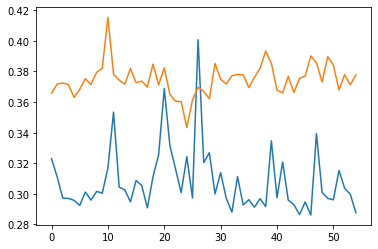

In [470]:
import matplotlib.pyplot as plt

# plt.plot( history.history['accuracy'] )
plt.plot( history.history['loss'] )
plt.plot( history.history['val_loss'] )
plt.show()

In [471]:
# predicting on the testing data

predictions = model.predict(train_x)

correct = 0
for i in range(len(predictions)):
    # print(f"{train_y[i]} predicted --> { (predictions[i][0]*100)//1 } %")

    if predictions[i] > 0.5 and train_y[i] == 1:
            correct = correct + 1

    if predictions[i] < 0.5 and train_y[i] == 0:
            correct = correct + 1

print(f"{correct} correct predictions out of {len(predictions)}")
print(f"accuracy = { str((correct / len(predictions)) * 100)[:5] } %")

787 correct predictions out of 891
accuracy = 88.32 %
